In [1]:
#%%
import numpy as np
import matplotlib.pyplot as pyplot
from cvxpy import *
import pandas as pd

In [2]:
#%% Data Imports

#Apparent power values assume pf=0.95
office = pd.read_csv('SF_Office_import.csv') #Office building - not used in model
CARE = pd.read_csv('CARE_import.csv') #CARE/FERA residential
a10 = pd.read_csv('a10_import.csv') #Fire station
e1 = pd.read_csv('e1_import.csv') #Residential
mbl = pd.read_csv('MBL_import.csv') #Medical baseline ???
solar = pd.read_csv('solar_import.csv')

In [3]:
#%% Parameters A - Direct Objective Inputs (1-2)

D_df = pd.read_csv('nodes.csv')

#1 - Value ranking of different customer categories (5=highest priority, 1=lowest)
R = np.array([[0, 0, 0, 0, 5, 4, 3, 2]])
#Remaining length-8 arrays are only 1 dimension. 
# They will only be used in constraints at a single time.

#Select hour numbers to use from load and solar data
t0 = 12
len_t = 4

#2 - Load total power for each node into D
D = D_df.iloc[t0:t0+len_t, [1,10,19,28,37,46,55,64]].to_numpy()
D_P = D_df.iloc[t0:t0+len_t, [4,13,22,31,40,49,58,67]].to_numpy()
D_Q = D_df.iloc[t0:t0+len_t, [7,16,25,34,43,52,61,70]].to_numpy()
#Index as: D[hour number, node number]

'''
#Future iterations may need demand split between critical and non-critical portions.
#The following loop provides a numbered index for all columns in D_df:
i = -1
for item in D_df.columns:
    i += 1
    print(i, item)
'''

'\n#Future iterations may need demand split between critical and non-critical portions.\n#The following loop provides a numbered index for all columns in D_df:\ni = -1\nfor item in D_df.columns:\n    i += 1\n    print(i, item)\n'

In [4]:
# %% Parameters B (3-8)

#3 - solar PV generation
month = 'June' #select month of solar data (June/September/December)
hourly_gen = np.array(solar[month+' (kW)'].values[t0:t0+len_t])
zeros = np.zeros(len_t)
s_S = np.array([zeros, hourly_gen, hourly_gen, zeros, zeros, zeros, zeros, zeros]).T
#Index as: s_S[hour number, node number]

#4 - battery energy (batteries at nodes 1 & 2, EV at 7)
j_max = np.array([0, 9.5, 9.5, 0, 0, 0, 0, 95])
j_start = np.array([0, 4.0, 4.0, 0, 0, 0, 0, 30])#arbitrarily chosen values

#5 - diesel fuel (diesel generator at node 3)
f_start = np.array([0, 0, 10, 0, 0, 0, 0, 0]) #arbitrarily chosen values

#6 - power ratings
b_rating = np.array([0, 8, 8, 0, 0, 0, 0, 20]) #battery
d_rating = np.array([0, 0, 10, 0, 0, 0, 0, 0])

#7 - power factors (currently is implicit 0.95 in D_df columns)
#pf = np.full((1,8), 0.95)

#8 - voltage limits
V_min = 0.95
V_max = 1.05

# %% Check available energy
print('D:',np.sum(D))
print('s_S:',np.sum(s_S))
print('j_start:',np.sum(j_start))
print('f_start:',np.sum(f_start))
print('energy available:',np.sum([np.sum(s_S),np.sum(j_start),np.sum(f_start)]))

D: 101.527095797
s_S: 25.200000000000003
j_start: 38.0
f_start: 10
energy available: 73.2


In [5]:
# %% Parameters C (9-11)

j_idx = np.arange(8)

#9 - Resistance and reactance
r = np.array([0,0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
x = np.array([0,0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

#10 - Max current
I_max = np.array([0, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4])

#11 - Adjacency matrix
A = np.array([[0, 1, 1, 1, 1, 1, 1, 1],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0]])
#A[i, j]=1 if i is the parent of j
#Node 0 has no parent

#Rho - Defines parent nodes in for loops
rho = np.array([0, 0, 0, 0, 0, 0, 0, 0])

In [6]:
#%% Parameters D (12-)

#12 - Time step
dt = 1

#13 - Inverter efficiencies
nu_s = 1 #solar
nu_b = 1 #battery
#Efficiency already included in generator output. 
#Only matters for solar because solar input is total solar energy,
#and for batteries because energy put in and out of system needs to be in terms of system.
#Note values are not yet built into constraints

# %% Optimization Variables
#Variable shape: (rows, columns)

#1 - Fraction of load served
F = Variable((len_t,8))

#2 - Load supplied (apparent, real, reactive)
l_S = Variable((len_t,8))
l_P = Variable((len_t,8))
l_Q = Variable((len_t,8))

#3 - Battery power dispatched (+) or stored (-)
b_S = Variable((len_t,8))
b_P = Variable((len_t,8))
b_Q = Variable((len_t,8))

#4 - Diesel power generated
d_S = Variable((len_t,8))
d_P = Variable((len_t,8))
d_Q = Variable((len_t,8))

#5 - Solar power (real and reactive)
s_P = Variable((len_t,8))
s_Q = Variable((len_t,8))
#Currently solar only provides real power: s_P = s_S (in constraints)
#So these are duplicative, but relevant if modeling inverter that can provide P and Q

#6 - Net power
s = Variable((len_t,8))
p = Variable((len_t,8))
q = Variable((len_t,8))

#7 - Voltage
V = Variable((len_t,8))

#8 - Energy stock
j = Variable((len_t,8)) #Battery state of charge
f = Variable((len_t,8)) #Diesel fuel available

#9-11 - Line variable
P = Variable((len_t,8)) #active power flow
Q = Variable((len_t,8)) #reactive power flow
L = Variable((len_t,8)) #squared magnitude of complex current

'''
#9-11 - Line  variables
P = Variable((8,8,t)) #active power flow
Q = Variable((8,8,t)) #reactive power flow
L = Variable((8,8,t)) #squared magnitude of complex current
# ValueError: Expressions of dimension greater than 2 are not supported.
# Alternative version (above) squeezes into 2 dimensions since all nodes 1-7 have parent 0. 
'''

'\n#9-11 - Line  variables\nP = Variable((8,8,t)) #active power flow\nQ = Variable((8,8,t)) #reactive power flow\nL = Variable((8,8,t)) #squared magnitude of complex current\n# ValueError: Expressions of dimension greater than 2 are not supported.\n# Alternative version (above) squeezes into 2 dimensions since all nodes 1-7 have parent 0. \n'

In [7]:
# %% Define objective function

#objective = Maximize( sum(F@R.T) )
objective = Minimize( -sum(F@R.T) )

# %% Constraints 0

#Nothing between node 0 and itself
#constraints = [ P[0] == 0, Q[0] == 0, L[0] == 0]
constraints = [ P[:,0] == 0, Q[:,0] == 0, L[:,0] == 0]
#Fix node 0 voltage to be 1 p.u.
#constraints += [ V[0] == 1 ]constraints += [ V[:,0] == 1 ]

In [8]:
# %% Constraints A (1-4)

#1 - Net power consumed at each node
constraints += [ p == l_P - b_P - d_P - s_P ]
constraints += [ q == l_Q - b_Q - d_Q - s_Q ]
constraints += [ s == l_S - b_S - d_S - s_S ]

#2 - No phantom batteries or generators
no_batteries = [0, 3, 4, 5, 6]
no_generator = [0, 1, 2, 4, 5, 6, 7]
no_solar = [0, 3, 4, 5, 6, 7]

for node in no_batteries:
    constraints += [ b_S[:, node] == 0 ]
    constraints += [ b_P[:, node] == 0 ]
    constraints += [ b_Q[:, node] == 0 ]
for node in no_generator:
    constraints += [ d_S[:, node] == 0 ]
    constraints += [ d_P[:, node] == 0 ]
    constraints += [ d_Q[:, node] == 0 ]
for node in no_solar:
    constraints += [ s_P[:, node] == 0 ]
    constraints += [ s_Q[:, node] == 0 ]
    
#3 - Define fraction of load served (may need to loop?)
#constraints += [ F == l_S/D ]
constraints += [ F == l_P/D_P ]

#4 - Guarantee full load for critical nodes
critical = [4, 5]
for node in critical:
    constraints += [ F[:, node] == 1. ]

#4.x - Power delivered cannot exceed demand
constraints += [ l_S <= D ]
constraints += [ l_P <= D_P ]
constraints += [ l_Q <= D_Q ]

#Need to limit apparent power. In Homework, it was done this way:
#constraints = [ s <= s_max ]
#where s is apparent power generated at each node, and s was generator limit

In [9]:
# %% Constraints B (5-6)

#5 - Battery state of charge
constraints += [ j[0] == j_start ]
if len_t > 1:
    for t in range(1,len_t):
        constraints += [ j[t] == j[t-1] - b_S[t-1]*dt]
for t in range(len_t):
    constraints += [ 0 <= j[t], j[t] <= j_max]

#6 - Fuel stock
constraints += [ f[0] == f_start ]
if len_t > 1:
    for t in range(1, len_t):
        constraints += [ f[t] == f[t-1] - d_S[t-1]*dt ]

In [10]:
# %% Constraints C (7-9, 14)

for t in range(len_t):
    for jj in j_idx:
        i = rho[jj]

        #7 - DistFlow equations
#        constraints += [ P[t,jj] == p[t,jj] + r[jj]*L[t,jj] + A[jj]@P[t,:] ] # Problematic constraint
        constraints += [ Q[t,jj] == q[t,jj] + x[jj]*L[t,jj] + A[jj]@Q[t,:] ]

#         #8 - Voltage drop
        constraints += [ V[t,jj] - V[t,i] == (r[jj]**2 + x[jj]**2)*L[t,jj] - 2*(r[jj]*P[t,jj].T + x[jj]*Q[t,jj].T) ]

#         #9 - Squared current magnitude (relaxed)
        constraints += [ quad_over_lin(vstack([P[t,jj],Q[t,jj]]), V[t,jj]) <= L[t,jj] ]

#         #14 - Definition of apparent power
#         constraints += [ norm(vstack([p[t,jj],q[t,jj]])) <= s[t,jj] ]
        # Homework only checked this relationship generation, this is for net power
        # MB note: instead of applying apparent power constraint for cumulative, apply to each source (l/s/b/d)
        
#         # New - Definition of apparent power for generation
        constraints += [ norm(vstack([l_P[t,jj],l_Q[t,jj]])) <= l_S[t,jj] ]
        constraints += [ norm(vstack([s_P[t,jj],s_Q[t,jj]])) <= s_S[t,jj] ]
        constraints += [ norm(vstack([b_P[t,jj],b_Q[t,jj]])) <= b_S[t,jj] ]
        constraints += [ norm(vstack([d_P[t,jj],d_Q[t,jj]])) <= d_S[t,jj] ]
        constraints += [ norm(vstack([sum(l_P[t,:]),sum(l_Q[t,:])])) <= sum(l_S[t,:]) ]
        constraints += [ norm(vstack([sum(s_P[t,:]),sum(s_Q[t,:])])) <= sum(s_S[t,:]) ]
        constraints += [ norm(vstack([sum(b_P[t,:]),sum(b_Q[t,:])])) <= sum(b_S[t,:]) ]
        constraints += [ norm(vstack([sum(d_P[t,:]),sum(d_Q[t,:])])) <= sum(d_S[t,:]) ]

In [11]:
# %% Constraints D (10)

#10 - Battery and solar only emit real power
# constraints += [ s_P == s_S ]
# constraints += [ b_P == b_S ]

'''
#Tried with sums
constraints += [ sum(l_S) <= sum(s_S)+sum(b_S)+sum(d_S)]
constraints += [ sum(l_P) <= sum(s_P)+sum(b_P)+sum(d_P)]
constraints += [ sum(l_Q) <= sum(s_Q)+sum(b_Q)+d_Q]
'''

'\n#Tried with sums\nconstraints += [ sum(l_S) <= sum(s_S)+sum(b_S)+sum(d_S)]\nconstraints += [ sum(l_P) <= sum(s_P)+sum(b_P)+sum(d_P)]\nconstraints += [ sum(l_Q) <= sum(s_Q)+sum(b_Q)+d_Q]\n'

In [12]:
# %% Constraints E (11-13)

for t in range(len_t):
    
    #11 - Battery (dis)charging limit
    constraints += [ -b_rating <= b_S[t], b_S[t] <= b_rating ]
    constraints += [ 0 <= b_Q[t] ]

    #12 - Generator output limit
    constraints += [ d_S[t] <= d_rating ]

#13 - Battery or generator does not discharge more than available
if len_t > 1:
    for t in range(1, len_t):
        constraints += [ b_S[t]*dt <= j[t-1] ]
        constraints += [ d_S[t]*dt <= f[t-1] ]
else:
    constraints += [ b_S[t]*dt <= j_start ]
    constraints += [ d_S[t]*dt <= f_start ]

In [13]:
# %% Constraints F (15-16)

for t in range(len_t):

    #15 - Allowed voltages
    constraints += [ V_min**2 <= V[t], V[t] <= V_max**2 ]

#16 - Current limit
constraints += [ L[t] <= I_max**2 ]

In [14]:
# # %% Constraints G (new)
# Ensure that power consumed/generated is greater than or equal to 0
constraints += [l_S >= 0, 
                l_P >= 0, 
                l_Q >= 0, 
                d_S >= 0,
                d_P >= 0, 
                d_Q >= 0, 
                s_P >= 0,  
                s_Q >= 0]

# Ensure that power supplied l is less than or equal to power generated
constraints += [sum(l_S) <= sum(b_S) + sum(d_S) + sum(s_S), 
                sum(l_P) <= sum(b_P) + sum(d_P) + sum(s_P),  
                sum(l_Q) <= sum(b_Q) + sum(d_Q) + sum(s_Q)]

In [15]:
# %%
prob = Problem(objective, constraints)
prob.solve()
print(prob.status)
print(prob.value)

# %%
for t in range(len_t):
    print("Time %3.0f"%(t))
    for jj in j_idx:
        print("Node %2.0f fraction served: %1.3f"%(jj, F[t,jj].value))

optimal_inaccurate
-45.41570173823102
Time   0
Node  0 fraction served: 0.000
Node  1 fraction served: 0.000
Node  2 fraction served: 0.000
Node  3 fraction served: 0.000
Node  4 fraction served: 1.000
Node  5 fraction served: 1.000
Node  6 fraction served: 1.000
Node  7 fraction served: 0.000
Time   1
Node  0 fraction served: 0.000
Node  1 fraction served: 0.000
Node  2 fraction served: 0.000
Node  3 fraction served: 0.000
Node  4 fraction served: 1.000
Node  5 fraction served: 1.000
Node  6 fraction served: 1.000
Node  7 fraction served: 0.000
Time   2
Node  0 fraction served: 0.000
Node  1 fraction served: 0.000
Node  2 fraction served: 0.000
Node  3 fraction served: 0.000
Node  4 fraction served: 1.000
Node  5 fraction served: 1.000
Node  6 fraction served: 1.000
Node  7 fraction served: 0.000
Time   3
Node  0 fraction served: 0.000
Node  1 fraction served: 0.000
Node  2 fraction served: 0.000
Node  3 fraction served: 0.000
Node  4 fraction served: 1.000
Node  5 fraction served: 1.

/opt/conda/lib/python3.8/site-packages/cvxpy/problems/problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


**Look at Underlying Demand/Supply/Generation Values at Each Node**

In [16]:
# Define function to take negative and positive data apart and cumulate
def get_cumulated_array(data, **kwargs):
    cum_arr = data.clip(**kwargs)
    cum_arr = np.cumsum(cum_arr, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum_arr[:-1]
    return d  

In [17]:
# Create dataframe of outputs
t = 1
outputs = pd.DataFrame({'App Demand':D[t],'App Supply':l_S.value[t], 'App Battery':b_S.value[t], 
                        'App Solar': s_S[t],'App Diesel':d_S.value[t], 
                        'Active Demand':D_P[t], 'Active Supply': l_P.value[t], 'Active Battery': b_P.value[t], 
                        'Active Solar':s_P.value[t], 'Active Diesel': d_P.value[t], 
                        'Reactive Demand': D_Q[t], 'Reactive Supply': l_Q.value[t], 'Reactive Battery':b_Q.value[t], 
                        'Reactive Solar': s_Q.value[t], 'Reactive Diesel': d_Q.value[t]}, 
                         dtype = float)
outputs = outputs.round(2)
outputs

,App Demand,App Supply,App Battery,App Solar,App Diesel,Active Demand,Active Supply,Active Battery,Active Solar,Active Diesel,Reactive Demand,Reactive Supply,Reactive Battery,Reactive Solar,Reactive Diesel
0,0.00,0.00,-0.00,0.0,0.0,0.00,-0.00,-0.00,0.0,-0.0,0.00,-0.0,0.0,0.0,-0.0
1,0.00,0.00,-0.00,3.5,0.0,0.00,-0.00,0.00,3.5,-0.0,0.00,-0.0,0.0,0.0,-0.0
2,0.00,0.00,-0.00,3.5,0.0,0.00,-0.00,0.00,3.5,-0.0,0.00,-0.0,0.0,0.0,-0.0
3,0.00,0.00,-0.00,0.0,0.0,0.00,-0.00,-0.00,0.0,0.0,0.00,-0.0,0.0,0.0,0.0
4,1.41,1.34,-0.00,0.0,0.0,1.34,1.34,-0.00,0.0,-0.0,0.44,0.0,0.0,0.0,-0.0
5,22.19,21.08,-0.00,0.0,0.0,21.08,21.08,-0.00,0.0,-0.0,6.93,0.0,0.0,0.0,-0.0
6,0.68,0.65,-0.00,0.0,0.0,0.65,0.65,-0.00,0.0,-0.0,0.21,0.0,0.0,0.0,-0.0
7,1.16,0.00,5.86,0.0,0.0,1.10,0.00,5.86,0.0,-0.0,0.36,0.0,0.0,0.0,-0.0


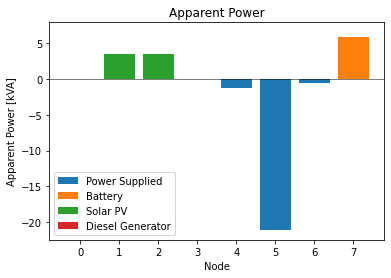

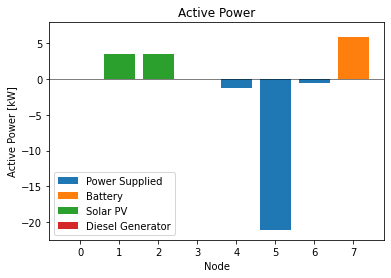

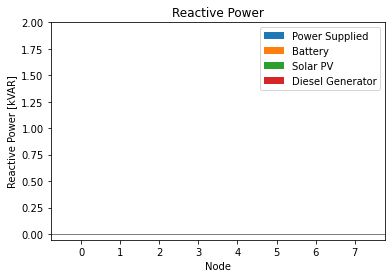

In [18]:
# Define function to create plots
import matplotlib.pyplot as plt
def plots(supp, batt, solar, diesel, title, ylabel):
    data = np.array([-supp, batt, solar, diesel])
    data_shape = np.shape(data)
    cumulated_data = get_cumulated_array(data, min=0)
    cumulated_data_neg = get_cumulated_array(data, max=0)
    row_mask = (data<0)
    cumulated_data[row_mask] = cumulated_data_neg[row_mask]
    data_stack = cumulated_data
    labels = ["Power Supplied", "Battery", "Solar PV", "Diesel Generator"]
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in np.arange(0, data_shape[0]):
        ax.bar(np.arange(data_shape[1]), data[i], bottom=data_stack[i], label=labels[i],)
    plt.axhline(color = 'black', linewidth = 0.5)
    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Node')
    maxes = [np.max(cumulated_data), np.max(data)]
    plt.ylim(top = np.max(maxes)+2)
    plt.show()

plots(outputs['App Supply'], outputs['App Battery'], outputs['App Solar'], outputs['App Diesel'], 
      'Apparent Power', 'Apparent Power [kVA]')    
# Plot Active Power
plots(outputs['Active Supply'], outputs['Active Battery'], outputs['Active Solar'], outputs['Active Diesel'], 
      'Active Power', 'Active Power [kW]')
# Plot Reactive Powern
plots(outputs['Reactive Supply'], outputs['Reactive Battery'], outputs['Reactive Solar'], outputs['Reactive Diesel'], 
      'Reactive Power', 'Reactive Power [kVAR]')

**Constraints Edited**

Objective function

- Changed objective function to max l_P*D_P
- Reason: with max l_S*D, l_P turned out to be zero

Constraints A
- Removed 7 from list of nodes w/o battery
- Add constraints requiring that b_P & b_Q be zero at non-battery nodes
- Add constraints requiring that d_P & d_Q be zero at non-diesel gen nodes
- Add constraints requiring that s_P & s_Q be zero at non-diesel gen nodes
- Add constraint that l_P and l_Q are less than or equal to D_P and D_Q
- (Temporarily) removed constraints for p, q, s (b/c originally seemed to make all gen at one node equal cons at one node, meaning it might be preventing power flow?). Need to figure out how to re-incorporate relationship between apparent/reactive/active power without leading to infeasible. 

Constraints C
- Added apparent power constraint for solar (since otherwise s_S and s_P/s_Q are not related at all)

Constraints E
- Add else condition limiting b_S and d_S for single time step (if len_t = 1) based on j_start and f_start
- Constraint 12: b_S should be d_S
- Should ratings instead impose constraints on real power P rather than apparent power S?

Constraints G (new)
- Add constraint requiring that l_S, l_P, l_Q, d_S, d_P, d_Q, s_P, s_Q be PSD
- Add constraint that sum(l_S) <= sum(b_S, d_S, s_S)
    - Ensures that power provided is less than or equal to power generated
- Same for _P and _Q
- Think that we don’t need the following, but would be good to get a second opinion:
    - Possibly add constraint that battery charged amount must be less than or equal to the sum of generation from diesel and solar minus energy provided l

Questions
- Does var[t] actually retrieve the row of the variable?
    - E.g., for Constraints E, are we actually setting the entire row of b_S for that variable to 0?


**Scratch Work**

In [19]:
# print('Demand:')
# D, D_P, D_Q

In [20]:
# print('Apparent power for solar:')
# s_S

In [21]:
# print('Apparent power for supply, battery, diesel gen, & solar:')
# [["{:.1f}".format(j.value[0, i]) for i in range(np.size(j.value))] for j in [l_S, b_S, d_S]]

In [22]:
# print('Active/real power for supply, battery, diesel gen, & solar:')
# [["{:.1f}".format(j.value[0, i]) for i in range(np.size(j.value))] for j in [l_P, b_P, d_P, s_P]]

In [23]:
# print('Reactive power for supply, battery, diesel gen, & solar:')
# [["{:.1f}".format(j.value[0, i]) for i in range(np.size(j.value))] for j in [l_Q, b_Q, d_Q, s_Q]]

In [24]:
# x = np.array(())
# for j in [l_S, b_S, d_S, l_P, b_P, d_P, s_P, l_Q, b_Q, d_Q, s_Q]:
#     for i in range(len(j.value[0])): 
#         x = np.append(x, j.value[0][i])
#     print(j, ': ', x)

In [25]:
# items = ['supply', 'battery', 'diesel gen']
# variables = [l_S, b_S, d_S]
# for j in range(3): 
#     print('\nApparent power for', items[j], ':')
#     for jj in j_idx:
#         print("Node %2.0f: %1.3f"%(jj, variables[j].value[0, jj]))

In [26]:
# mins = []
# [mins.append(np.min(i)) for i in v]
# mins = np.min(mins)
# mins

In [27]:
# # Create plots
# import matplotlib.pyplot as plt
# def plots(supp, batt, solar, diesel, title, ylabel):
#     ind = np.arange(8)
#     plt.bar(ind, -supp, label = 'Supply')
#     plt.bar(ind, batt, label = 'Battery', bottom = solar)
#     plt.bar(ind, solar, label = 'Solar PV')
#     plt.bar(ind, diesel, label = 'Diesel Generator')
#     plt.title(title)
#     plt.ylabel(ylabel)
#     plt.xlabel('Node')
#     plt.legend()
#     plt.axhline(color = 'black', linewidth = 0.5)
#     mins
#     plt.show()
# plots(outputs['App Supply'], outputs['App Battery'], outputs['App Solar'], outputs['App Diesel'], 
#       'Apparent Power', 'Apparent Power [kVA]')

In [28]:
# # Create plots
# import matplotlib.pyplot as plt
# def plots(supp, batt, solar, diesel, title, ylabel):
#     ind = np.arange(8)
#     width = 0.25
#     plt.bar(ind-2*width, -supp, width, label = 'Supply')
#     plt.bar(ind-width, batt, width, label = 'Battery')
#     plt.bar(ind+width, solar, width, label = 'Solar PV')
#     plt.bar(ind+2*width, diesel, width, label = 'Diesel Generator')
#     plt.title(title)
#     plt.ylabel(ylabel)
#     plt.xlabel('Node')
#     plt.xticks(range(8))
#     plt.legend()
#     plt.axhline(color = 'black', linewidth = 0.5)
#     mins
#     plt.show()
# plots(outputs['App Supply'], outputs['App Battery'], outputs['App Solar'], outputs['App Diesel'], 
#       'Apparent Power', 'Apparent Power [kVA]')